In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm_notebook as tqdm
from scipy.optimize import minimize, least_squares
from scipy.stats import norm
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

In [2]:
def trim(X, percent):
    ''' Trims X with the percent input by removing the top and bottom
    (1-percent)/2 observations and then returns a matrix of binary variables
    indicating rows of X that would not be trimmed
    '''

    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))

    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]

    return np.prod(t_ind, axis = 1)

## Non-Linear Control IV

\begin{align*}
Q &= P \beta_d + f(T) + u_d \\
Q &= P \beta_s + g(W) + u_s \\
P &= (\beta_d - \beta_s)^{-1} \, \left(  g(W) - f(T) + u_s - u_d \right)  \\
E(u_d \, | \, T, W) &= 0 \\
E(u_s \, | \, T, W) &= 0 \\
\end{align*}

where $f(T)$ is some nonlinear function of $T$ and $g(W)$ is some nonlinear function of $W$. 

Let $\alpha = (\beta_d - \beta_s)^{-1}$. Firstly, note that we have:
\begin{align*}
E(P\,|\,T) &= \alpha (E(W) - f(T)) \\
E(P\,|\,W) &= \alpha (g(W) - E(T)) \\
E(P\,|\,T,W) &= \alpha(g(W) - f(T)) 
\end{align*}

Now, differencing $Q$ with its conditional expectation, we have:
\begin{align*}
Q - E(Q \,|\,T) &= (P - E(P\,|\,T))\beta_d + (f(T) - E(f(T) \,|\,T)) + (u_d - E(u_d|T))\\
&= (\alpha(g(W) - E(W)))\beta_d + 0 + u_d 
\end{align*}
Now, note that we also have:
$$E(P\,|\,T,W) - E(P\,|\,T) = \alpha (g(W) - E(W))$$
hence we can regress 
$$(Q - E(Q \,|\,T)) \sim (E(P\,|\,T,W) - E(P\,|\,T)) $$ 
to estimate $\beta_d$

### Step by Step Walkthough

#### Variable Generation

In [3]:
n = 2000

# Params
beta_d = -7
beta_s = 3
def f(t): return (np.sin((t-0.75)*(2*np.pi))+1.1)*2
def g(w): return 3*np.power(1 + np.exp(-w*8+3), -1)


# Error terms
u_d = np.random.normal(size = n)/3
u_s = np.random.normal(size = n)/3

# Variables
w   = np.random.random(n)
t   = np.random.random(n)
p   = (1/(beta_d - beta_s))*(g(w) - f(t) + u_s - u_d)
q   = beta_d*p + f(t) + u_d
u_s = q - beta_s*p - g(w)

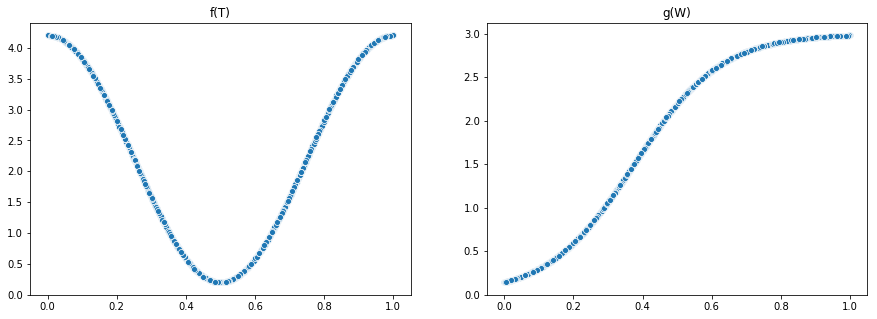

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
sns.scatterplot(t, f(t), ax = ax[0])
ax[0].set_title('f(T)');
sns.scatterplot(w, g(w), ax = ax[1])
ax[1].set_title('g(W)');

#### Conditional Expectations

NW Kernel used to make consistent estimates of $CE(Y\,|\,X=arg)$ where $Y = f(X)$ and $arg$ is the set of points at which to make the conditional expectation estimates. Trimming is needed to ensure consistency.

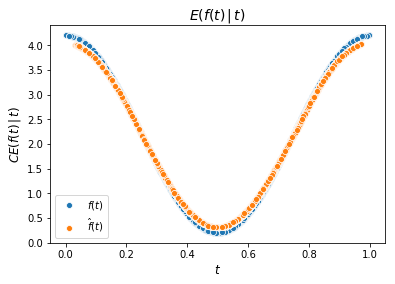

In [5]:
## Testing the CE function (using optimal bandwidth parameter 1/5)

# Trimming t
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.95))
t_trim = t[trim_idx]

# Making conditional estimates of f(t) given t
ce_ft_t  = nparam.KernelReg(endog=[f(t)], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)[0]


# Comparing conditional expectation of f(t) given t with the true value of f(t)
sns.scatterplot(x = t, y = f(t))
sns.scatterplot(x = np.array(t_trim).flatten(), y = np.array(ce_ft_t).flatten())
plt.title('$E(f(t) \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(f(t) \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',                  fontsize = 12);
plt.legend(['$f(t)$', '$\hat{f}(t)$']);

In [6]:
# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T,W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[t,w], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(tw_trim)).fit(tw_trim)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(w_trim)]).fit(w_trim)

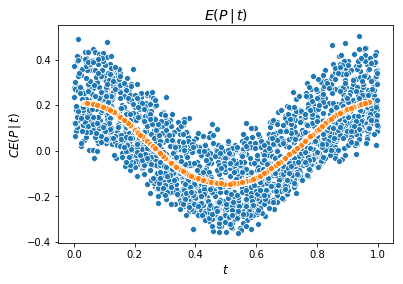

In [7]:
sns.scatterplot(y= p, x = t)
sns.scatterplot(y= ce_p_t.flatten(), x = np.array(t_trim).flatten())
plt.title('$E(P \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',               fontsize = 12);

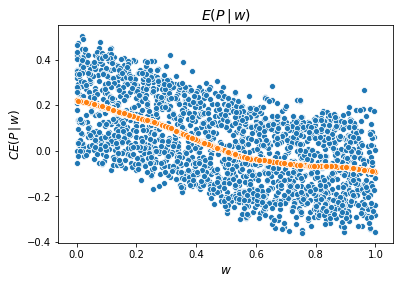

In [8]:
# CE(P|w) is a linear function of g(t) as argued above. 
sns.scatterplot(y= p, x = w)
sns.scatterplot(y= ce_p_w.flatten(), x = np.array(w_trim).flatten())
plt.title('$E(P \, | \, w)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, w)$', fontsize = 12);
plt.xlabel('$w$',               fontsize = 12);

#### Main Regression

In [12]:
# Since we trimmed t, we also have to trim prices and quantities by the same index
p_trim = p[trim_idx]
q_trim = q[trim_idx]

data_df = pd.DataFrame([q_trim, p_trim, ce_p_t.flatten(), ce_p_tw.flatten(), ce_p_w.flatten(), ce_q_t.flatten()]).T
data_df.columns = ['q', 'p', 'ce_p_t', 'ce_p_tw', 'ce_p_w', 'ce_q_t']

fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w ', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
fit.summary(yname = 'Q - CE(Q|T)', xname = ['Intercept', 'βd'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q - CE(Q|T)   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 1.281e+04
Date:                Thu, 04 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:06:07   Log-Likelihood:                -202.56
No. Observations:                1900   AIC:                             409.1
Df Residuals:                    1898   BIC:                             420.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2284      0.006     35.407      0.000       0.216       0.241
βd            -7.1475      0.063   -113.182      0.000      -7.271      -7.024
==============================================================================
Omnibus:                        0.896   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.961
Skew:                          -0.041   Prob(JB):                        0.618
Kurtosis:                       2.927   Cond. No.                         9.88
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [25]:
# Estimation errors
demand_elas_est = fit.params['ce_p_w']
print('Price elasticity of demand estimation error (MAPE):  {0:.2%}'.format(np.abs(1-demand_elas_est/beta_d)))
print('Price elasticity of demand estimation error (MAE):   {0:.2}'.format(np.abs(demand_elas_est-beta_d)))

Price elasticity of demand estimation error (MAPE):  2.66%
Price elasticity of demand estimation error (MAE):   0.19


### Monte Carlo Sim

In [9]:
mc_trials = 10
beta_d_hat_est = []

for trial in tqdm(range(mc_trials)):

    n = 1000
    
    # Params
    beta_d = -7
    beta_s = 3
    def f(t): return (np.sin((t-0.75)*(2*np.pi))+1.1)*2
    def g(w): return 3*np.power(1 + np.exp(-w*8+3), -1)


    # Error terms
    u_d = np.random.normal(size = n)/3
    u_s = np.random.normal(size = n)/3

    # Variables
    w   = np.random.random(n)
    t   = np.random.random(n)
    p   = (1/(beta_d - beta_s))*(g(w) - f(t) + u_s - u_d)
    q   = beta_d*p + f(t) + u_d
    u_s = q - beta_s*p - g(w)

    # Trimming 
    trim_idx = np.where(trim(np.matrix(t).T, percent = 0.9))
    t_trim = t[trim_idx]
    p_trim = p[trim_idx]
    q_trim = q[trim_idx]

    # Conditional expectation estimates
    tw = np.array([t,w]).T
    tw_trim = np.array([t,w]).T[trim_idx]
    w_trim  = np.array(w[trim_idx])
    t_trim  = np.array(t[trim_idx])

    # Estimation of CE(Q | T)
    ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                                  bw=[bw_silverman(t_trim)]).fit(t_trim)

    # Estimation of CE(P | W)
    ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                                 bw=[bw_silverman(w_trim)]).fit(w_trim)
    
    
    # Estimation of CE(P | T)
    ce_p_t, _  = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c', 
                                  bw=[bw_silverman(t_trim)]).fit(t_trim)
    
    
    # Estimation of CE(P | T,W)
    ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='cc', 
                                 bw=bw_silverman(tw_trim)).fit(tw_trim)

    # Regression
    p_trim = p[trim_idx]
    q_trim = q[trim_idx]

    data_df = pd.DataFrame([q_trim, p_trim, ce_p_t.flatten(), ce_p_tw.flatten(), ce_p_w.flatten(), ce_q_t.flatten()]).T
    data_df.columns = ['q', 'p', 'ce_p_t', 'ce_p_tw', 'ce_p_w', 'ce_q_t']

    fit = smf.ols('np.add(q, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t) ', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    beta_d_hat_est.append(fit.params['np.add(ce_p_tw, -ce_p_t)'])

Mean estimate:   -7.0967
Median estimate: -7.0793


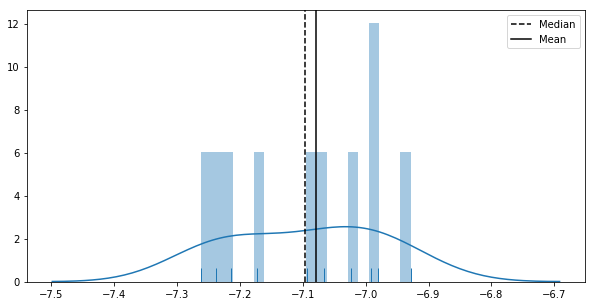

In [11]:
fig = plt.figure(figsize = (10,5))

sns.distplot(beta_d_hat_est, bins = 20, norm_hist = 1, rug = True);
plt.axvline(np.mean(beta_d_hat_est),   color='k', linestyle='--')
plt.axvline(np.median(beta_d_hat_est), color='k', linestyle='-')

plt.legend({'Mean': np.mean(beta_d_hat_est), 'Median':np.median(beta_d_hat_est)});
print('Mean estimate:   {0:.4f}'.format(np.mean(beta_d_hat_est)))
print('Median estimate: {0:.4f}'.format(np.median(beta_d_hat_est)))

In [12]:
print('Estimation error (MAE):  {0:.2}'.format(np.mean(np.abs(np.array(beta_d_hat_est) - beta_d))))
print('Estimation error (RMSE): {0:.2}'.format(np.sqrt(np.mean(np.square(np.array(beta_d_hat_est) - beta_d)))))
print('Estimation error (MAPE): {0:.2%}'.format(np.mean(np.abs(1-np.divide(beta_d_hat_est, beta_d)))))

Estimation error (MAE):  0.12
Estimation error (RMSE): 0.15
Estimation error (MAPE): 1.67%


## Regression with Actual Data

In [57]:
data_df = pd.read_csv('../data/processed/ercot_load_price_2018.csv')

In [58]:
data_df.head()

,date,hour,price,datetime,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd,date_fmt,month,price_rel,load_rel,day
0,01/01/2018,1,27.68,01/01/2018 01:00,11425.979115,-6.1,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.506805,1.200389,1
1,01/01/2018,2,27.62,01/01/2018 02:00,11408.418023,-6.3,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.503538,1.198544,1
2,01/01/2018,3,27.43,01/01/2018 03:00,11405.198365,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.493195,1.198206,1
3,01/01/2018,4,27.95,01/01/2018 04:00,11450.560138,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.521502,1.202972,1
4,01/01/2018,5,27.38,01/01/2018 05:00,11631.337459,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.490474,1.221964,1


In [59]:
wind_output_df = pd.read_csv('../data/wind/wind_output_ercot.csv')[['time-date stamp', 'Total Wind Output, MW']]
wind_output_df.columns = ['datetime', 'wind_output']
wind_output_df['date'] = wind_output_df['datetime'].apply(lambda x: str(x)[:10])
wind_output_df['hour'] = wind_output_df['datetime'].apply(lambda x: int(str(x)[11:13])+1)
wind_output_df.head()

,datetime,wind_output,date,hour
0,01/01/2018 00:00:00,4644,01/01/2018,1
1,01/01/2018 01:00:00,4582,01/01/2018,2
2,01/01/2018 02:00:00,4570,01/01/2018,3
3,01/01/2018 03:00:00,4540,01/01/2018,4
4,01/01/2018 04:00:00,4550,01/01/2018,5


In [60]:
data_df = data_df.merge(wind_output_df.iloc[:,1:], on = ['date', 'hour'])

In [62]:
data_df['season'] = data_df['month'].apply(lambda x: int(1+np.floor(x/4)))

In [63]:
# Add logged values
data_df['log_lr']  = np.log(data_df['load_rel'])
data_df.loc[data_df['price']>0,'log_pr'] = np.log(data_df['price_rel'].loc[data_df['price_rel']>0])

# Drop cases where any variable is missing data
reg_data_df = data_df[['wind_output', 'temperature', 'log_lr', 'log_pr', 'hour', 'season']].dropna().copy()

In [64]:
cut_low, cut_high = reg_data_df['log_lr'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('log_lr < @cut_high & log_lr > @cut_low')

cut_low, cut_high = reg_data_df['log_pr'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('log_pr < @cut_high & log_pr > @cut_low')

In [65]:
t = np.array(reg_data_df['temperature'])
w = np.array(reg_data_df['wind_output'])
p = np.array(reg_data_df['log_pr'])
q = np.array(reg_data_df['log_lr'])
h = np.array(reg_data_df['hour'])

# Trimming 
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.98))
t_trim = t[trim_idx]
p_trim = p[trim_idx]
q_trim = q[trim_idx]

# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                              bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w_trim)]).fit(w_trim)


# Estimation of CE(P | T,W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[t,w], reg_type='lc', var_type='cc', 
                             bw=bw_silverman(tw_trim)).fit(tw_trim)

In [69]:
# Regression
data_df = pd.DataFrame([q_trim, p_trim, ce_p_w.flatten(), ce_q_t.flatten(), h[trim_idx], reg_data_df['season'].iloc[trim_idx]]).T
data_df.columns = ['q', 'p','ce_p_w', 'ce_q_t', 'hour', 'season']

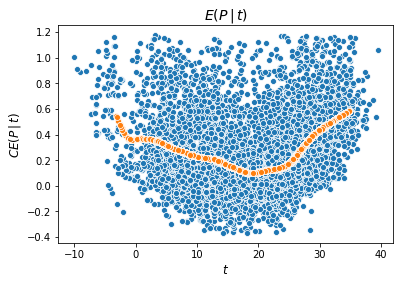

In [70]:
# CE(P|w) is a linear function of f(t) 
sns.scatterplot(y= p, x = t)
sns.scatterplot(y= ce_p_t.flatten(), x = np.array(t_trim).flatten())
plt.title('$E(P \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',               fontsize = 12);

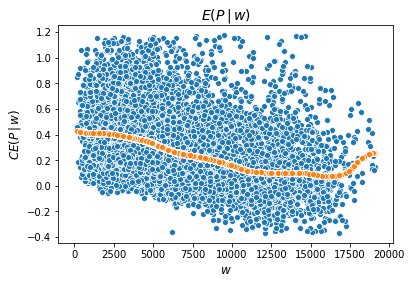

In [71]:
# CE(P|w) is a linear function of g(w) 
sns.scatterplot(y= p, x = w)
sns.scatterplot(y= ce_p_w.flatten(), x = np.array(w_trim).flatten())
plt.title('$E(P \, | \, w)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, w)$', fontsize = 12);
plt.xlabel('$w$',               fontsize = 12);

In [72]:
fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.322
Date:                Tue, 26 Mar 2019   Prob (F-statistic):             0.0684
Time:                        15:02:05   Log-Likelihood:                 6334.7
No. Observations:                7376   AIC:                        -1.267e+04
Df Residuals:                    7374   BIC:                        -1.265e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0113      0.006     -1.743      0.081      -0.024       0.001
ce_p_w         0.0495      0.027      1.823      0.068      -0.004       0.103
==============================================================================
Omnibus:                      136.696   Durbin-Watson:                   0.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.722
Skew:                           0.261   Prob(JB):                     1.40e-37
Kurtosis:                       3.529   Cond. No.                         9.16
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

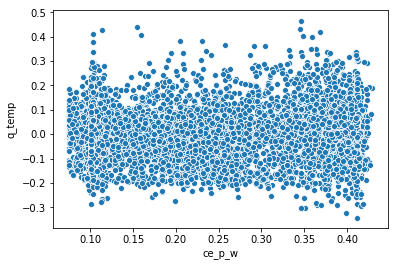

In [73]:
data_df['q_temp'] = data_df['q'] - data_df['ce_q_t']
sns.scatterplot(x = 'ce_p_w', y = 'q_temp', data = data_df)

In [74]:
fit = smf.ols('np.add(q, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t) + C(season) + C(hour)', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     75.05
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:02:06   Log-Likelihood:                 7619.9
No. Observations:                7376   AIC:                        -1.519e+04
Df Residuals:                    7349   BIC:                        -1.500e+04
Df Model:                          26                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0700      0.009     -7.704      0.000      -0.088      -0.052
C(season)[T.2.0]             0.0022      0.010      0.223      0.824      -0.017       0.021
C(season)[T.3.0]             0.0343      0.011      3.131      0.002       0.013       0.056
C(season)[T.4.0]             0.0087      0.013      0.648      0.517      -0.018       0.035
C(hour)[T.2.0]              -0.0217      0.002     -8.860      0.000      -0.026      -0.017
C(hour)[T.3.0]              -0.0336      0.003    -10.055      0.000      -0.040      -0.027
C(hour)[T.4.0]              -0.0416      0.004    -11.209      0.000      -0.049      -0.034
C(hour)[T.5.0]              -0.0365      0.004     -9.189      0.000      -0.044      -0.029
C(hour)[T.6.0]              -0.0081      0.004     -1.973      0.049      -0.016   -5.33e-05
C(hour)[T.7.0]               0.0332      0.005      6.517      0.000       0.023       0.043
C(hour)[T.8.0]               0.0354      0.006      6.218      0.000       0.024       0.047
C(hour)[T.9.0]               0.0448      0.006      7.385      0.000       0.033       0.057
C(hour)[T.10.0]              0.0565      0.006      9.140      0.000       0.044       0.069
C(hour)[T.11.0]              0.0637      0.006      9.936      0.000       0.051       0.076
C(hour)[T.12.0]              0.0677      0.006     11.022      0.000       0.056       0.080
C(hour)[T.13.0]              0.0681      0.006     10.837      0.000       0.056       0.080
C(hour)[T.14.0]              0.0712      0.007     10.929      0.000       0.058       0.084
C(hour)[T.15.0]              0.0704      0.007      9.922      0.000       0.057       0.084
C(hour)[T.16.0]              0.0728      0.007      9.750      0.000       0.058       0.087
C(hour)[T.17.0]              0.0844      0.007     12.012      0.000       0.071       0.098
C(hour)[T.18.0]              0.1096      0.006     17.405      0.000       0.097       0.122
C(hour)[T.19.0]              0.1270      0.005     23.230      0.000       0.116       0.138
C(hour)[T.20.0]              0.1380      0.005     28.075      0.000       0.128       0.148
C(hour)[T.21.0]              0.1412      0.004     33.081      0.000       0.133       0.150
C(hour)[T.22.0]              0.1238      0.004     35.351      0.000       0.117       0.131
C(hour)[T.23.0]              0.0837      0.003     31.686      0.000       0.079       0.089
np.add(ce_p_tw, -ce_p_t)     0.0133      0.026      0.504      0.615      -0.038       0.065
==============================================================================
Omnibus:                      269.011   Durbin-Watson:                   0.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.642
Skew:                           0.231   Prob(JB):       

### Daily

In [15]:
data_df = pd.read_csv('../data/processed/ercot_load_price_2018.csv')
data_df = data_df.groupby(['date'])['temperature', 'wind_speed', 'price_rel', 'load_rel'].mean().reset_index()

# Add logged values
data_df['log_lr']  = np.log(data_df['load_rel'])
data_df.loc[data_df['price_rel']>0,'log_pr'] = np.log(data_df['price_rel'].loc[data_df['price_rel']>0])

# Drop cases where any variable is missing data
reg_data_df = data_df[['wind_speed', 'temperature', 'log_lr', 'log_pr']].dropna().copy()

In [16]:
cut_low, cut_high = reg_data_df['log_lr'].quantile([0.05, 0.95])
reg_data_df = reg_data_df.query('log_lr < @cut_high & log_lr > @cut_low')

cut_low, cut_high = reg_data_df['log_pr'].quantile([0.05, 0.95])
reg_data_df = reg_data_df.query('log_pr < @cut_high & log_pr > @cut_low')

cut_low, cut_high = reg_data_df['wind_speed'].quantile([0.05, 0.95])
reg_data_df = reg_data_df.query('wind_speed < @cut_high & wind_speed > @cut_low')

In [18]:
t = np.array(reg_data_df['temperature'])
w = np.array(reg_data_df['wind_speed'])
p = np.array(reg_data_df['log_pr'])
q = np.array(reg_data_df['log_lr'])

# Trimming 
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.99))
t_trim = t[trim_idx]
p_trim = p[trim_idx]
q_trim = q[trim_idx]

# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                              bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w_trim)]).fit(w_trim)


# Estimation of CE(P | T,W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[t,w], reg_type='lc', var_type='cc', 
                             bw=bw_silverman(tw_trim)).fit(tw_trim)

# Regression
data_df = pd.DataFrame([q_trim, p_trim, ce_p_w.flatten(), ce_q_t.flatten(), ce_p_tw.flatten()]).T
data_df.columns = ['q', 'p','ce_p_w', 'ce_q_t', 'ce_p_tw']

In [23]:
fit = smf.ols('np.add(q, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.000
Date:                Tue, 26 Mar 2019   Prob (F-statistic):              0.159
Time:                        13:37:33   Log-Likelihood:                 350.68
No. Observations:                 259   AIC:                            -697.4
Df Residuals:                     257   BIC:                            -690.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0008      0.008     -0.093      0.926      -0.017       0.015
np.add(ce_p_tw, -ce_p_t)     0.1336      0.094      1.414      0.157      -0.052       0.319
==============================================================================
Omnibus:                        3.441   Durbin-Watson:                   0.967
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                4.032
Skew:                           0.020   Prob(JB):                        0.133
Kurtosis:                       3.610   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

(0, 168)

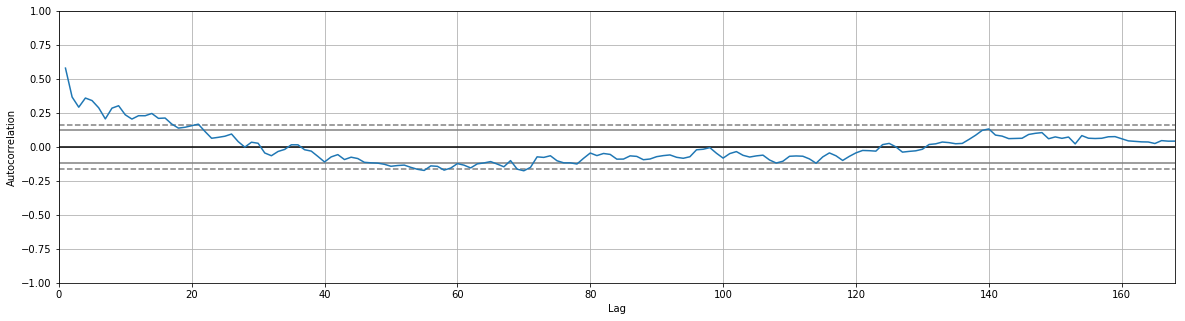

In [333]:
plt.figure(figsize = (20,5))
pd.plotting.autocorrelation_plot(pd.Series(fit.resid))
pylab.xlim([0,24*7])

### CET

In [185]:
data_df = pd.read_csv('../data/processed/ercot_load_price_2018.csv')

In [186]:
data_df.head()

,date,hour,price,datetime,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd,date_fmt,month,price_rel,load_rel,day
0,01/01/2018,1,27.68,01/01/2018 01:00,11425.979115,-6.1,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.506805,1.200389,1
1,01/01/2018,2,27.62,01/01/2018 02:00,11408.418023,-6.3,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.503538,1.198544,1
2,01/01/2018,3,27.43,01/01/2018 03:00,11405.198365,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.493195,1.198206,1
3,01/01/2018,4,27.95,01/01/2018 04:00,11450.560138,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.521502,1.202972,1
4,01/01/2018,5,27.38,01/01/2018 05:00,11631.337459,-6.4,0.0,0,5.520471,-0.474999,-5.499998,2018-01-01,1,1.490474,1.221964,1


In [188]:
samples = int(2e4)

# Subset dataframe for relevant variables
em_sample_df = data_df[['price', 'load', 'date', 'hour', 'month', 'temperature']].dropna().copy()

# Drop outliers
cut_low, cut_high = em_sample_df['price'].quantile([0.05, 0.95])
em_sample_df = em_sample_df.query('price < @cut_high & price > @cut_low')
cut_low, cut_high = em_sample_df['load'].quantile([0.05, 0.95])
em_sample_df = em_sample_df.query('load < @cut_high & load > @cut_low')

# Create two subsample dataframes
em_sample_df_1 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

# Concat these two sample dfs
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1).copy()

em_concat_df.head()

,price_1,load_1,date_1,hour_1,month_1,temperature_1,price_2,load_2,date_2,hour_2,month_2,temperature_2
0,16.43,10411.248888,03/08/2018,16,3,19.9,18.96,11577.862824,08/01/2018,8,8,24.4
1,17.44,11348.766519,09/22/2018,6,9,21.3,21.77,11218.962121,09/27/2018,8,9,13.5
2,28.45,9784.532269,11/19/2018,6,11,4.8,25.62,16778.718443,06/25/2018,12,6,30.6
3,23.37,11693.022296,11/07/2018,7,11,21.4,15.90,9587.216862,01/16/2018,3,1,-3.1
4,24.46,12473.094193,02/13/2018,11,2,4.2,20.33,11037.397995,06/21/2018,6,6,21.7


In [189]:
em_concat_df = em_concat_df.query('price_1 > 0 & load_1 > 0 & price_2 > 0 & load_2 > 0')
em_concat_df['ln_load_rel']  = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel'] = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))

#### Nonlinear CET Estimation

In [190]:
## Nonlinear model for CET estimation

reg_data_df = em_concat_df[['temperature_1', 'temperature_2', 'hour_1', 'hour_2', 'ln_load_rel', 'ln_price_rel', 'month_1', 'month_2']].dropna().query(
    'month_1 == month_2').copy()

# Trimming
cut_low, cut_high = reg_data_df['ln_load_rel'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('ln_load_rel < @cut_high & ln_load_rel > @cut_low')

cut_low, cut_high = reg_data_df['ln_price_rel'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('ln_price_rel < @cut_high & ln_price_rel > @cut_low')

cut_low, cut_high = reg_data_df['temperature_1'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('temperature_1 < @cut_high & temperature_1 > @cut_low')

cut_low, cut_high = reg_data_df['temperature_2'].quantile([0.025, 0.975])
reg_data_df = reg_data_df.query('temperature_2 < @cut_high & temperature_2 > @cut_low')

# CE
t = np.array(reg_data_df[['temperature_1', 'temperature_2', 'hour_1', 'hour_2']])
p = np.array(reg_data_df['ln_price_rel'])
q = np.array(reg_data_df['ln_load_rel'])

# Estimation of CE(Q | T) = g(T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='cccc', 
                              bw=bw_silverman(t)).fit(t)

In [192]:
# Regression
reg2_data_df = pd.DataFrame([p, ce_q_t.flatten(), reg_data_df['month_1']]).T
reg2_data_df.columns = ['p', 'ce_q_t', 'month']

fit = smf.ols('p ~ ce_q_t:C(month)', data = reg2_data_df).fit(cov_type='HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      p   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     75.93
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          1.17e-142
Time:                        15:11:54   Log-Likelihood:                 71.382
No. Observations:                1399   AIC:                            -116.8
Df Residuals:                    1386   BIC:                            -48.60
Df Model:                          12                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0003      0.006      0.055      0.956      -0.012       0.012
ce_q_t:C(month)[1.0]      0.9774      0.214      4.561      0.000       0.557       1.397
ce_q_t:C(month)[2.0]      0.5729      0.163      3.521      0.000       0.254       0.892
ce_q_t:C(month)[3.0]      0.6795      0.138      4.928      0.000       0.409       0.950
ce_q_t:C(month)[4.0]      0.8641      0.193      4.486      0.000       0.487       1.242
ce_q_t:C(month)[5.0]      1.3585      0.098     13.862      0.000       1.166       1.551
ce_q_t:C(month)[6.0]      1.2590      0.093     13.547      0.000       1.077       1.441
ce_q_t:C(month)[7.0]      1.3224      0.163      8.122      0.000       1.003       1.642
ce_q_t:C(month)[8.0]      1.3338      0.120     11.102      0.000       1.098       1.569
ce_q_t:C(month)[9.0]      1.5664      0.106     14.729      0.000       1.358       1.775
ce_q_t:C(month)[10.0]     0.7357      0.211      3.480      0.001       0.321       1.150
ce_q_t:C(month)[11.0]     1.1014      0.269      4.092      0.000       0.574       1.629
ce_q_t:C(month)[12.0]     1.0327      0.230      4.499      0.000       0.583       1.483
==============================================================================
Omnibus:                        9.216   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               12.554
Skew:                          -0.030   Prob(JB):                      0.00188
Kurtosis:                       3.460   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [195]:
np.mean(fit.params[1:])**(-1)

0.937227634659382

In [187]:
# wind_output_df = pd.read_csv('../data/wind/wind_output_ercot.csv')[['time-date stamp', 'Total Wind Output, MW']]
# wind_output_df.columns = ['datetime', 'wind_output']
# wind_output_df['date'] = wind_output_df['datetime'].apply(lambda x: str(x)[:10])
# wind_output_df['hour'] = wind_output_df['datetime'].apply(lambda x: int(str(x)[11:13])+1)
# wind_output_df.head()